In [12]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import groundingdino.datasets.transforms as T
import numpy as np
from PIL import Image
import os
import torch

In [31]:
os.chdir('./creating_labels')
from maxarseg.segment import dino_img_load, filter_on_box_area_mt2

In [2]:
root ="./creating_labels/models"
CONFIG_PATH = os.path.join(root, "GDINO/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))
WEIGHTS_PATH = os.path.join(root, "GDINO/groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))
IMAGE_PATH = "./exampleData/maxarSample.png"


./creating_labels/models/GDINO/GroundingDINO_SwinT_OGC.py ; exist: True
./creating_labels/models/GDINO/groundingdino_swint_ogc.pth ; exist: True


In [3]:
im = Image.open(IMAGE_PATH).convert("RGB")
np_img_rgb = np.asarray(im)[:600,:600]

In [4]:
np_img_rgb.shape

(600, 600, 3)

In [5]:
np_img_rgb[0]

array([[ 94, 103,  76],
       [ 91, 100,  73],
       [ 87,  96,  69],
       ...,
       [ 21,  36,  35],
       [ 23,  39,  38],
       [ 22,  38,  37]], dtype=uint8)

In [6]:
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [22]:
image_transformed = dino_img_load(np_img_rgb)

TEXT_PROMPT = 'tree' #'house' #'tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30
boxes, logits, phrases = predict(model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
#Note: boxes are in the format cxcywh (centre, width and height, cx, cy being center of box, w, h being width and height.)

In [16]:
h, w, _ = np_img_rgb.shape
img_res = 0.30517578125
tmp_boxes = boxes.clone()
print(tmp_boxes.shape)
tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])

area_mt2 = torch.prod(tmp_boxes[:,:2], dim=1) * img_res**2
print(area_mt2.shape)

torch.Size([131, 4])
torch.Size([131])


In [39]:
import matplotlib.pyplot as plt
from torchvision.ops import box_convert

def plotDinoBoxes(np_img_rgb, boxes):
    fig, ax = plt.subplots()
    ax.imshow(np_img_rgb)

    h, w, _ = np_img_rgb.shape
    tmp_boxes = boxes.clone()
    tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=tmp_boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    
    for box in xyxy:
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color="red")
        ax.add_patch(rect)
    plt.show()

In [54]:
#Stats on the boxes
img_res = 0.30517578125
h, w, _ = np_img_rgb.shape
tmp_boxes = boxes.clone()
tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])

area_mt2 = torch.prod(tmp_boxes[:,2:], dim=1) * img_res**2

In [56]:
area_mt2.max()

tensor(33527.5469)

### ECDF plot of the area
Useful for knowing where to set the threshold

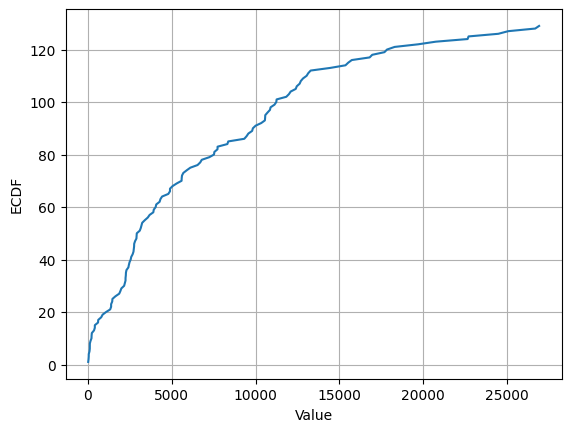

In [30]:
import matplotlib.pyplot as plt

img_res = 0.30517578125
keep_ix = filter_on_box_area_mt2(boxes, np_img_rgb.shape[:2], img_res, min_area_mt2 = 0, max_area_mt2 = 6000) #360_000
#print(area_mt2_np[keep_ix])
area_mt2_np = area_mt2.numpy()
array_sorted = np.sort(area_mt2_np[keep_ix])
cumulative_counts = np.arange(1, len(area_mt2_np[keep_ix]) + 1) #/ len(area_mt2_np)
plt.plot(array_sorted, cumulative_counts)
plt.xlabel('Area')
plt.ylabel('Cumulative count')
plt.grid(True)
plt.show()

In [36]:
print('Num. of boxes:', keep_ix[keep_ix].shape[0])

Num. of boxes: 129


Num. of boxes: 129


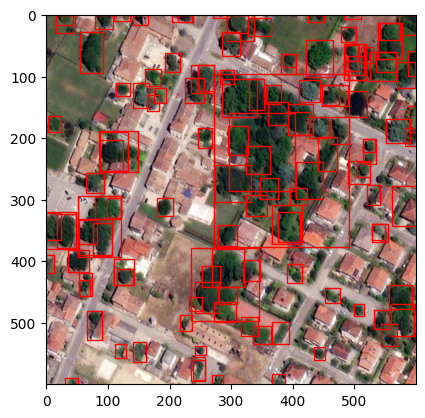

In [40]:
print('Num. of boxes:', keep_ix[keep_ix].shape[0])
plotDinoBoxes(np_img_rgb, boxes[keep_ix])